In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score


In [119]:
#random state
rd = 42

# Introduction

In this case, we will be analyzing the 'Users vs Bots Classification' dataset from Kaggle. This dataset contains profile data collected from VK.com, Russia’s largest social network, with the goal of distinguishing between genuine users and automated bots. Each row is an user,it includes a variety of user characteristics, featuring both numerical and categorical variables.

For more information, you can view the dataset here:
[Users vs Bots Classification on Kaggle](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification/data)

For this case, we will apply two different unsupervised learning approaches to predict the data. First, we will use PCA (Principal Component Analysis) to identify and extract the most important features. After that, we will experiment with different clustering methods to find the model that best classifies the data into users and bots.

Although the dataset contains a target variable, since we are focusing solely on unsupervised approaches, we will remove the target variable from the training set. However, we will keep it in the test set in order to evaluate the performance of our models and measure the quality of our predictions.

In [120]:
# Download latest version
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\david\.cache\kagglehub\datasets\juice0lover\users-vs-bots-classification\versions\3


# EDA

In [121]:
user_bots = pd.read_csv(r"C:\Users\david\.cache\kagglehub\datasets\juice0lover\users-vs-bots-classification\versions\3\bots_vs_users.csv")
user_bots.head()

has_domain has_birth_date has_photo can_post_on_wall can_send_message  \
0        1.0            1.0       0.0              0.0              0.0   
1        1.0            1.0       0.0              0.0              0.0   
2        1.0            1.0       0.0              0.0              0.0   
3        1.0            1.0       0.0              0.0              0.0   
4        1.0            1.0       0.0              0.0              0.0   

  has_website gender has_short_name has_first_name has_last_name  ...  \
0         0.0    1.0            1.0            1.0           1.0  ...   
1         0.0    1.0            1.0            1.0           1.0  ...   
2         0.0    1.0            1.0            1.0           1.0  ...   
3         0.0    1.0            1.0            1.0           1.0  ...   
4         0.0    1.0            1.0            1.0           1.0  ...   

  ads_ratio avg_views  posting_frequency_days phone_numbers_ratio  \
0       NaN       NaN                     NaN                 NaN   
1       NaN       NaN                     NaN                 NaN   
2       NaN       NaN                     NaN                 NaN   
3       NaN       NaN                     NaN                 NaN   
4       NaN       NaN                     NaN                 NaN   

  avg_text_uniqueness     city has_occupation occupation_type_university  \
0                 NaN  Unknown        Unknown                    Unknown   
1                 NaN  Unknown        Unknown                    Unknown   
2                 NaN  Unknown        Unknown                    Unknown   
3                 NaN  Unknown        Unknown                    Unknown   
4                 NaN  Unknown        Unknown                    Unknown   

  occupation_type_work has_personal_data  
0              Unknown           Unknown  
1              Unknown           Unknown  
2              Unknown           Unknown  
3              Unknown           Unknown  
4              Unknown           Unknown  

[5 rows x 60 columns]

In [122]:
user_bots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [123]:
user_bots.describe()

target  posts_count    avg_likes  links_ratio  hashtags_ratio  \
count  5874.000000  1391.000000  1391.000000  1391.000000     1391.000000   
mean      0.500000    18.629044    19.552487     0.156463        0.143918   
std       0.500043     4.231994    41.954881     0.202730        0.187085   
min       0.000000     1.000000     0.000000     0.000000        0.000000   
25%       0.000000    20.000000     0.400000     0.000000        0.000000   
50%       0.500000    20.000000     7.600000     0.100000        0.050000   
75%       1.000000    20.000000    26.075000     0.200000        0.200000   
max       1.000000    20.000000   894.900000     1.000000        1.000000   

       avg_keywords  avg_text_length  attachments_ratio  avg_comments  \
count   1391.000000      1391.000000        1391.000000   1391.000000   
mean       7.730661       544.752035           0.895945      0.610812   
std       11.278711       746.728130           0.170084      2.461709   
min        0.000000         0.000000           0.000000      0.000000   
25%        1.100000        86.600000           0.850000      0.000000   
50%        3.400000       267.800000           0.950000      0.000000   
75%        7.850000       616.850000           1.000000      0.200000   
max       61.600000      5841.250000           1.000000     64.050000   

       reposts_ratio    ads_ratio     avg_views  posting_frequency_days  \
count    1391.000000  1391.000000   1391.000000             1391.000000   
mean        0.433638     0.002667    623.834788               66.330065   
std         0.397830     0.033136   1617.635460              154.970296   
min         0.000000     0.000000      0.000000                0.000000   
25%         0.050000     0.000000      9.125000                1.980000   
50%         0.300000     0.000000    268.950000               30.950000   
75%         0.900000     0.000000    746.050000               89.480000   
max         1.000000     0.950000  41415.700000             2866.590000   

       phone_numbers_ratio  avg_text_uniqueness  
count          1391.000000          1391.000000  
mean              0.000568             0.668009  
std               0.009545             0.229815  
min               0.000000             0.000000  
25%               0.000000             0.580000  
50%               0.000000             0.710000  
75%               0.000000             0.830000  
max               0.300000             1.000000

In [124]:
print(f'The dataset has a shape of:{user_bots.shape}')

The dataset has a shape of:(5874, 60)


### Check Target data balance

<Axes: >

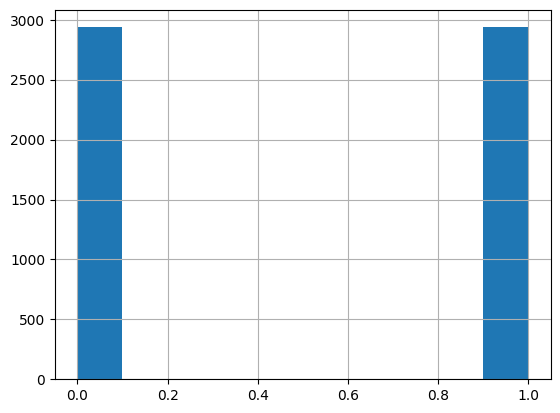

In [125]:
# Chack how many bots and users wew have on the data
user_bots['target'].hist()

The dataset appears to have a similar number of samples for both users and bots. This balance suggests it is a good choice for training, as there is no significant class imbalance.

### Duplicated values 

In [126]:
duplicates = user_bots.duplicated()
print(f'The number of duplicated rows are:{duplicates.sum()}')

The number of duplicated rows are:2616


We have a high number of duplicated values in the dataset. However, since this is general data about users, we cannot be certain that these duplicates represent the same user multiple times — it’s possible that different users simply share similar characteristics. Since our goal is to predict whether an instance is a user or a bot, we should not remove these duplicated rows for now. They could contain important patterns that help distinguish between the two classes, so it’s important to keep them at this stage.

### Categorical Values

To prepare the data for PCA, we need to encode the 'City' column, since it contains string values that PCA cannot process directly. To do this, we will use the Ordinal Encoder function, which maps each unique category in the column to an integer value. 
We will replace "Unknown" and NaN values with the number 2, so that the encoder starts assigning mapping integers from 3 onward, avoiding any conflicts with the special category we created.

In [127]:
encoder = OrdinalEncoder()
encoded_values = encoder.fit_transform(user_bots[['city']])
encoded_values_shifted = encoded_values + 3
user_bots['city'] = encoded_values_shifted

### Missing Values and NaN values

The data has already been pre-processed by the author, who handled the missing values as follows:

- For numerical features, missing values were left as NaN.

- For categorical features, missing values were replaced with "unknown."

In both cases, we will encode "Unknown" and NaN values as 2. This will create a separate category that the algorithm can recognize and will also allow us to pass the data through PCA without issues.

In [128]:
user_bots = user_bots.replace('Unknown', 2)
user_bots = user_bots.fillna(2)

In [129]:
X = user_bots.drop(columns=['target'],axis=1)
y = user_bots['target']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rd)
print(f'The size of the training data is:{X_train.shape}')
print(f'The size of the test data is:{X_test.shape}')

The size of the training data is:(3935, 59)
The size of the test data is:(1939, 59)


# PCA and Clustering

A PCA (Principal Component Analysis) model will be applied to reduce the dataset’s dimensionality, keeping only the top 10 features that explain the most variability. The goal is to simplify the dataset, making it easier for the clustering algorithm to process and analyze

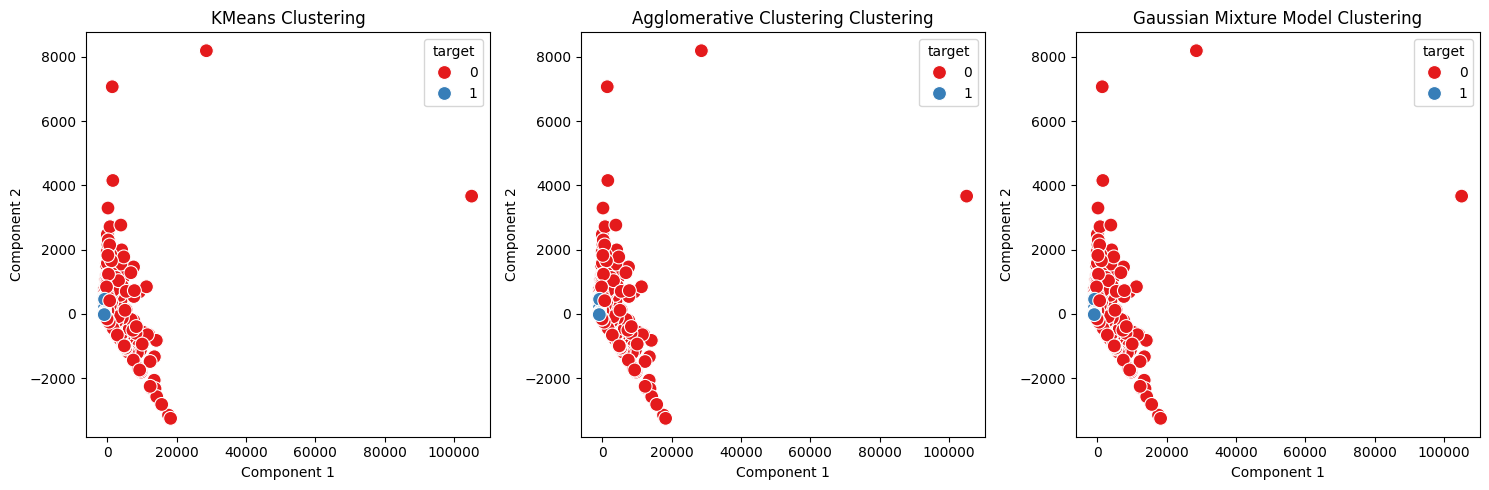

Best Model: Gaussian Mixture Model with Accuracy: 0.5105724600309438


In [ ]:
# Function to visualize clustering results
def plot_clusters(X, y, model_name, ax):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', s=100, ax=ax)
    ax.set_title(f'{model_name} Clustering')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

# Function to apply PCA for dimensionality reduction
def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

# Function to apply clustering models and evaluate
def apply_clustering_models(X_train, X_test, y_train, y_test):
    # Encode y_train for coloring in scatter plot
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    # Apply PCA to reduce the data to 2 dimensions
    X_train_pca = apply_pca(X_train)
    X_test_pca = apply_pca(X_test)

    # List of clustering algorithms to test
    clustering_algorithms = [
        ('KMeans', KMeans(n_clusters=2, random_state=42)),
        ('Agglomerative Clustering', AgglomerativeClustering(n_clusters=2)),
        ('Gaussian Mixture Model', GaussianMixture(n_components=2, random_state=rd))
    ]
    
    # Set up plotting
    fig, axes = plt.subplots(1, len(clustering_algorithms), figsize=(15, 5))

    best_accuracy = 0
    best_model = None
    best_y_pred = None
    best_model_name = ""

    for idx, (name, model) in enumerate(clustering_algorithms):
        # Fit the model on X_train_pca
        model.fit(X_train_pca)
        
        # Predict on X_test_pca
        if hasattr(model, 'predict'):
            y_test_pred = model.predict(X_test_pca)
        else:
            # Some models like Agglomerative and Spectral don't have 'predict' method
            y_test_pred = model.fit_predict(X_test_pca)
        
        # Map predictions to the correct labels (0 and 1)
        y_test_pred_mapped = le.inverse_transform(y_test_pred)
        
        # Compute accuracy on the test set
        accuracy = accuracy_score(y_test, y_test_pred_mapped)
        
        # If the accuracy is the best, store the result
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_y_pred = y_test_pred
            best_model_name = name
        
        # Visualize the clustering results
        plot_clusters(X_test_pca, y_test, name, axes[idx])

    plt.tight_layout()
    plt.show()
    
    return best_model_name, best_accuracy

best_model_name, best_accuracy = apply_clustering_models(X_train, X_test, y_train, y_test)

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")


# Conclusions 

After reviewing the results from the model we created earlier, the best accuracy we achieved was 51%. This is not an ideal result for this type of dataset. In this case, we only used unsupervised models, which likely contributed to the poor performance. Although we attempted to improve accuracy by applying PCA and experimenting with different clustering models, the results did not improve significantly.

Therefore, it seems the main issue lies in the choice of models. Perhaps if we had tried supervised models—like others who have worked on this dataset on Kaggle—we could have achieved better results.

Nonetheless, the main objective of this case was to evaluate the performance of unsupervised models. We conclude that, although unsupervised models may not deliver the best results in every situation, they are still valuable tools to consider for future projects. With better preprocessing or with a different dataset, these models might perform much better.